<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod3/rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod3/rf.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

[Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) and [Random Forests](https://en.wikipedia.org/wiki/Random_forest)
---
_homl3 ch7_

In [58]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

# Wisdom of the crowd
- A group of predictors usually make better predictions than the best individual predictor
  - they are called an *ensemble*
  - this technique is called *ensemble learning*
  - an ensemble learning algorithm is called an *ensemble method*, such as
    - voting classifiers, 
    - bagging and pasting ensembles, 
    - random forests, 
    - boosting, and stacking ensembles


# Voting Classifiers
- two types:  
  - hard voting classifier and soft voting classifier
- hard voting classifier
  - aggregates the predictions from a group of diverse classifiers
  - the class that gets the most votes is the ensemble’s prediction
- voting classifier often achieves a higher accuracy than the best classifier in the ensemble
  - even true for each classifier slightly better than random guessing
  - if the voting classifier has enough members 
    - and they are sufficiently diverse,
    - and they are sufficiently independent from each other
    - this is an ideal condition, in the real world,
      - these classifiers are trained on the same dataset
      - so they make similar errors and reduce the ensemble's accuracy
  - the principle behind this phenomenon is *the law of large numbers* 
  - it is implemented as the sklearn class VotingClassifier

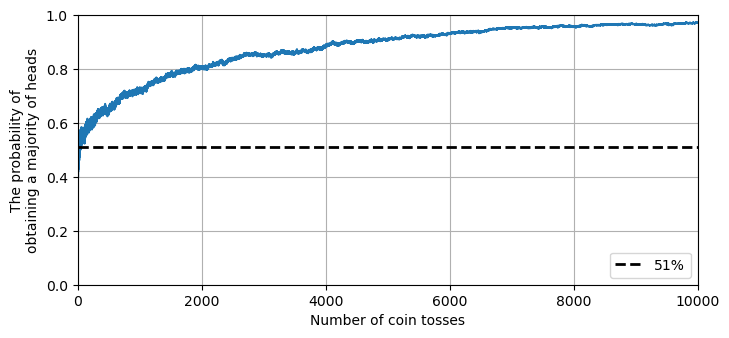

In [59]:
# An analog demonstrating the `Wisdom of the crowd`
# 1. toss a slightly biased coin that has a 51% chance of heads,
# simulating each learner can only get 51% right
# the probability of obtaining a majority of heads
# - after 1,000 tosses is above 70%
# - after 5,000 tosses is above 90%

heads_proba = 0.51
np.random.seed(42)

tosses = (np.random.rand(10000, 1000) < heads_proba).astype(np.int32)
heads = tosses.cumsum(axis=0)
times = np.arange(1, 10001).reshape(-1, 1)
majority = (heads >= np.ceil((times+1)/2)).astype(np.int32)
majorities = majority.sum(axis=1)
majority_probs = majorities/1000

fig1, axes1 = plt.subplots(figsize=(8, 3.5))
axes1.plot(majority_probs)
axes1.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
axes1.set_xlabel("Number of coin tosses")
axes1.set_ylabel("The probability of\nobtaining a majority of heads")
axes1.legend(loc="lower right")
axes1.axis([0, 10000, 0, 1])
axes1.grid()

In [60]:
majority_probs[[1000,5000,9999]]

array([0.725, 0.91 , 0.973])

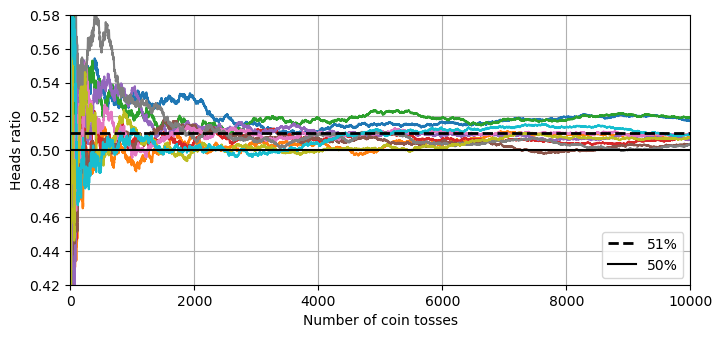

In [61]:
# 2. the law of large numbers
# 10 persons, each tosses this biased coin until 10,000 times
# everyone gets heads with a heads ratio converged to 51%
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / times

fig2, axes2 = plt.subplots(figsize=(8, 3.5))
axes2.plot(cumulative_heads_ratio)
axes2.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
axes2.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
axes2.set_xlabel("Number of coin tosses")
axes2.set_ylabel("Heads ratio")
axes2.legend(loc="lower right")
axes2.axis([0, 10000, 0.42, 0.58])
axes2.grid()

In [62]:
# 3. Exploit VotingClassifier
# give it a list of name/predictor pairs, 
# and use it like a normal classifier.

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = skds.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    # blueprints in the attribute estimators
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
# when fitting a VotingClassifier, 
# a copy is made from each blueprint then fitted
# the fitted members are in the attribute named_estimators_
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [63]:
# the score of each member learner is less than the ensemble's
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [64]:
voting_clf.score(X_test, y_test)

0.912

## Hard voting vs. soft voting
- hard voting votes by majority
- soft voting votes by probability

In [65]:
# 1. hard voting
# the final prediction is the prediction by the majority
# `voting_clf.predict` performs hard voting
# i.e. decided by the majority
voting_clf.predict(X_test[:1]), [clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

(array([1]), [array([1]), array([1]), array([0])])

### soft voting
- supported by the method `predict_proba()`
- it predicts the class with the highest class probability 
  - averaged over all the individual classifiers
- It often achieves higher performance than hard voting 
  - because it gives more weight to highly confident votes
- turned on by setting the voting hyperparameter to "soft"
  - requires that all members can estimate class probabilities
  - ⚠️ SVC does not estimate class probabilities by default
    - needs to be enabled by setting its `probability` hyperparameter to be True

In [66]:
# 2. enable soft voting then retrain model
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

In [67]:
mem_probs = [clf.predict_proba(X_test[:1]) for clf in voting_clf.estimators_]
voting_clf.predict_proba(X_test[:1]), mem_probs

(array([[0.51627522, 0.48372478]]),
 [array([[0.49899618, 0.50100382]]),
  array([[0.48, 0.52]]),
  array([[0.56982947, 0.43017053]])])

In [68]:
np.mean(mem_probs, axis=0)

array([[0.51627522, 0.48372478]])

# Bagging and Pasting
- There are two popular ways to get a diverse set of member predictors
  - one uses very different training algorithms on the same training set, or
  - the other one uses the same training algorithm for every member predictor 
    - but trains them on different random subsets of the training set
      - sampling the training set with replacement is called `bagging`
        - short for `bootstrap aggregating`
      - sampling the training set without replacement is called `pasting`
      - both bagging and pasting are scalable,
        - i.e can be processed in parallel
- generally, the ensemble has a similar bias but a lower variance than a member predictor

## Bagging and Pasting in Scikit-Learn
- both are supported by 
  - BaggingClassifier class for classification
  - BaggingRegressor for regression
- bagging is by default (`bootstrap=True`) since it often results in better models
  - since its training samples for each predictor are drawn from the whole training set
  - `bootstrap=False` for pasting
- `n_jobs` specifies the number of CPU cores to use for training and predictions
  - `n_jobs=-1`  uses all available cores
- A BaggingClassifier automatically performs soft voting instead of hard voting 
  - if the base classifier has a predict_proba() method, 
    - such as decision tree classifiers

In [69]:
# 1.  train an ensemble of 500 decision tree classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

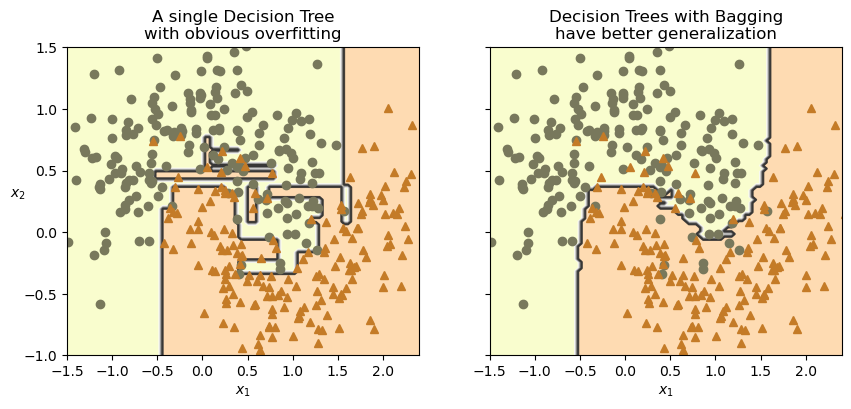

In [73]:
# 2.  A single decision tree vs. a bagging ensemble of 500 trees

def plot_decision_boundary(ax, clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    ax.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    ax.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        ax.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    ax.axis(axes)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig3, axes3 = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plot_decision_boundary(axes3[0], tree_clf, X_train, y_train)
axes3[0].set_title("A single Decision Tree\nwith obvious overfitting")

plot_decision_boundary(axes3[1], bag_clf, X_train, y_train)
axes3[1].set_title("Decision Trees with Bagging\nhave better generalization")
axes3[1].set_ylabel("");

## Out-of-Bag Evaluation


## Random Patches and Random Subspaces

# Random Forests
- A random forest is an ensemble of decision trees
  - each trains on a different random subset of the training set
  - the ensemble’s prediction is the one that gets the most votes 

# References
- [sklearn: Ensembles: Gradient boosting, random forests, bagging, voting, stacking](https://scikit-learn.org/stable/modules/ensemble.html)